<a href="https://colab.research.google.com/github/ali-workshop/Satellite_image_fire_detection-Level-intermediate-highest-accuracy/blob/main/Satellite_image_fire_detection_(Level%3Dintermediate)highest_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Define the path for the train, test and validation data

import os

cwd= os.getcwd()

training_data_path= os.path.join(cwd,"train")
testing_data_path= os.path.join(cwd,"test")
validation_data_path= os.path.join(cwd,"valid")

In [ ]:
import cv2
from pathlib import Path
from xgboost import XGBClassifier
from keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, precision_score
import seaborn as sb
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

In [ ]:
training_data_df= process_img(training_data_path)
testing_data_df= process_img(testing_data_path)
validation_data_df= process_img(validation_data_path)

training_data_df.head()

Filepath       Label
6968   C:\Users\hadis\Thesis\train\nowildfire\-73.509...  nowildfire
19125  C:\Users\hadis\Thesis\train\wildfire\-71.92163...    wildfire
21460  C:\Users\hadis\Thesis\train\wildfire\-73.18062...    wildfire
7953   C:\Users\hadis\Thesis\train\nowildfire\-73.685...  nowildfire
28315  C:\Users\hadis\Thesis\train\wildfire\-78.12113...    wildfire

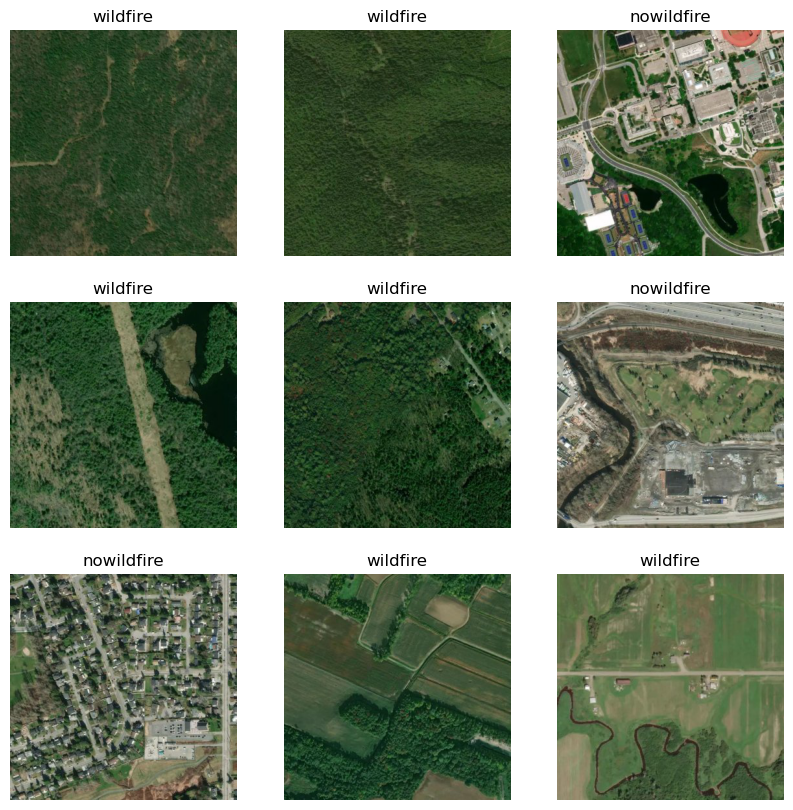

In [ ]:
def show_sample_images(df, num_images):

    # Randomly select a subset of images
    sample_df = df.sample(num_images)

    # Create a grid of subplots for displaying the images
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

    # Loop through each image and display it in a subplot
    for i, ax in enumerate(axs.flat):
        # Get the image and label from the dataframe
        img = plt.imread(sample_df.iloc[i].Filepath)
        label = sample_df.iloc[i].Label

        # Display the image in the subplot
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    # Show the plot
    plt.show()

show_sample_images(training_data_df,9)

In [ ]:
# We first create an ImageDataGenerator object with a rescaling factor of 1/255 so the model doesn't
# favor higher numbers
data_generator = ImageDataGenerator(dtype="float32",rescale=1./255)

# Just to handle an error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def auc_plotter(auc):
    roc_auc= auc
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

### SVC

In [ ]:
# Split the training data into training and testing sets
train_files, test_files = train_test_split(training_data_df, test_size=0.3, random_state=42)

batch_size = 32

# Define a generator for the training data
svm_training_generator = data_generator.flow_from_dataframe(train_files,
                                        x_col='Filepath',
                                        y_col='Label',
                                        shuffle=True,
                                        batch_size = batch_size,
                                        target_size = (128,128),
                                        class_mode = 'categorical')

# Define a generator for the testing data
svm_testing_generator = data_generator.flow_from_dataframe(
        test_files,
        x_col='Filepath',
        y_col='Label',
        shuffle=True,
        batch_size = batch_size,
        target_size = (128,128),
        class_mode = 'categorical')

x_train, y_train = svm_training_generator.next()
x_test, y_test = svm_testing_generator.next()

# This converts the labels back to their original indices since they are of the form of one-hot-encoded
# vector, the result is a 1D array of class indices, representing class labels for corresponding images in X_train
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Flatten the images into a 2D array, since SVMs expect 2D input arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Found 21175 validated image filenames belonging to 2 classes.
Found 9075 validated image filenames belonging to 2 classes.


In [ ]:
# Define the hyperparameter grid for SVC
svm_param_grid = {'C':[0.01,0.1,1,10],
              'kernel': ['polynomial','rbf', 'sigmoid'],
              'random_state': [101]}

In [ ]:
svm_model = GridSearchCV(SVC(), svm_param_grid, refit = True, verbose = 3)

# Train your SVM model on the entire training data
svm_model.fit(x_train, y_train)
best_params = svm_model.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, kernel=rbf, random_state=101;, score=0.571 total time=   0.0s
[CV 2/5] END C=0.01, kernel=rbf, random_state=101;, score=0.571 total time=   0.0s
[CV 3/5] END C=0.01, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END C=0.01, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 5/5] END C=0.01, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END C=0.01, kernel=sigmoid, random_state=101;, score=0.571 total time=   0.

In [ ]:
y_pred = svm_model.predict(x_test)
print(best_params)
print('\n-----------------------------------------------\n')
print(classification_report(y_test,y_pred))

{'C': 10, 'kernel': 'rbf', 'random_state': 101}

-----------------------------------------------

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.94      0.94      0.94        18

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



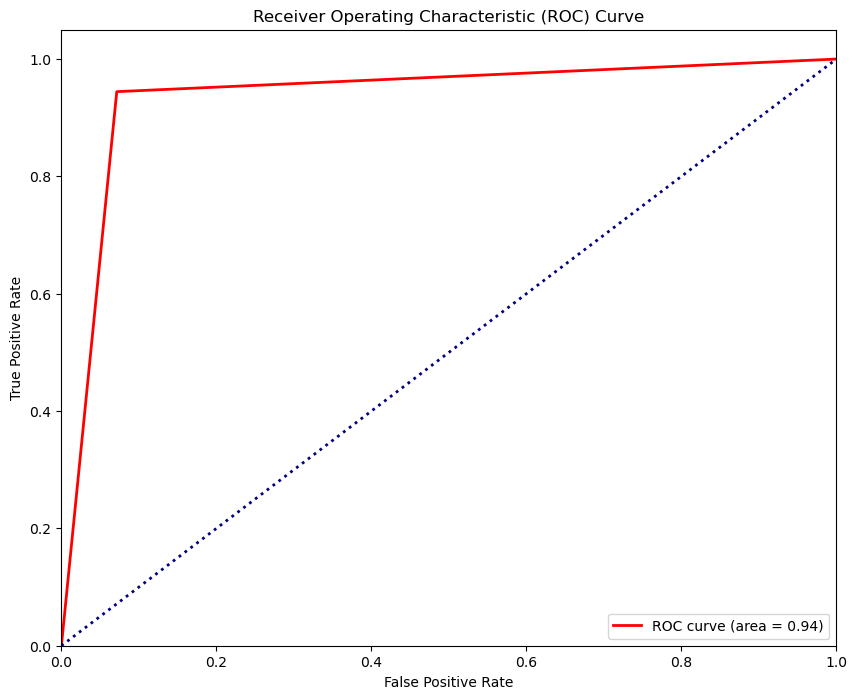

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(x_train.shape, x_test.shape)

# The .98 is a parameter that indicates the principal components required to explain 98% of the variance in the dataset
pca= PCA(.98)

pca_train= pca.fit_transform(x_train)
pca_test= pca.transform(x_test)
print('-----After PCA-------\n')
print(pca_train.shape, pca_test.shape)
print("Number of Components: ", pca.n_components_)
print("Number of Original Features: ", pca.n_features_)

(32, 49152) (32, 49152)
-----After PCA-------

(32, 27) (32, 27)
Number of Components:  27
Number of Original Features:  49152


In [ ]:
svm_model_pca = GridSearchCV(SVC(), svm_param_grid, refit = True, verbose = 3)

# Train your SVM model on the entire training data
svm_model_pca.fit(pca_train, y_train)
best_params = svm_model_pca.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, kernel=polynomial, random_state=101;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, kernel=rbf, random_state=101;, score=0.571 total time=   0.0s
[CV 2/5] END C=0.01, kernel=rbf, random_state=101;, score=0.571 total time=   0.0s
[CV 3/5] END C=0.01, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END C=0.01, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 5/5] END C=0.01, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END C=0.01, kernel=sigmoid, random_state=101;, score=0.571 total time=   0.

In [ ]:
y_pred = svm_model_pca.predict(pca_test)
print(best_params)
print('\n-----------------------------------------------\n')
print(classification_report(y_test,y_pred))

{'C': 10, 'kernel': 'rbf', 'random_state': 101}

-----------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.57      0.73        14
           1       0.75      1.00      0.86        18

    accuracy                           0.81        32
   macro avg       0.88      0.79      0.79        32
weighted avg       0.86      0.81      0.80        32



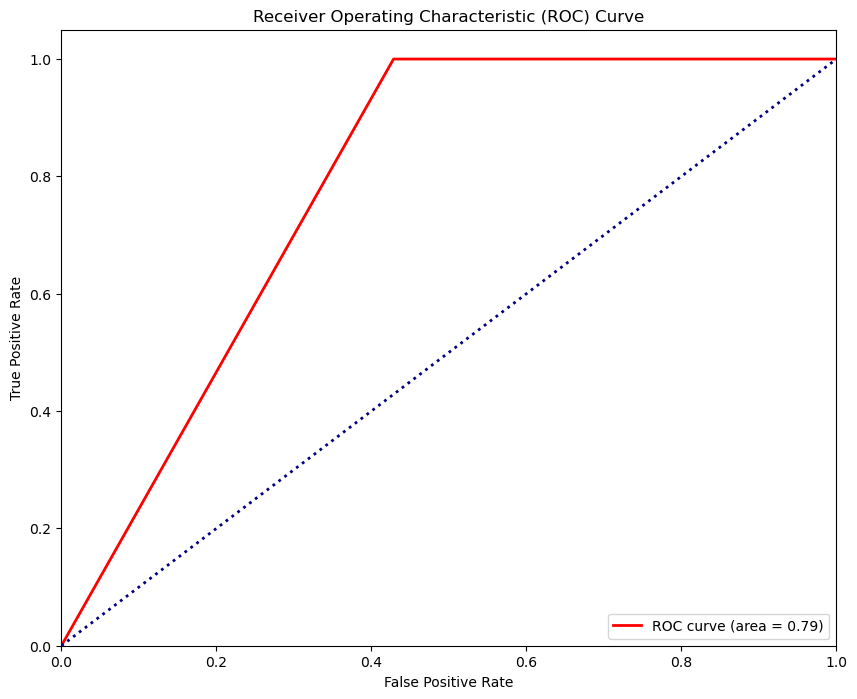

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

auc_plotter(roc_auc)

### Random Forest

In [ ]:
# Split the training data into training and testing sets
train_files, test_files = train_test_split(training_data_df, test_size=0.3, random_state=42)

batch_size = 32

# Define a generator for the training data
rf_training_generator = data_generator.flow_from_dataframe(train_files,
                                        x_col='Filepath',
                                        y_col='Label',
                                        shuffle=True,
                                        batch_size = batch_size,
                                        target_size = (128,128),
                                        class_mode = 'categorical')

# Define a generator for the testing data
rf_testing_generator = data_generator.flow_from_dataframe(
        test_files,
        x_col='Filepath',
        y_col='Label',
        shuffle=True,
        batch_size = batch_size,
        target_size = (128,128),
        class_mode = 'categorical')


x_train, y_train = rf_training_generator.next()
x_test, y_test = rf_testing_generator.next()

# This converts the labels back to their original indices since they are of the form of one-hot-encoded
# vector, the result is a 1D array of class indices, representing class labels for corresponding images in X_train
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Flatten the images into a 2D array, since SVMs expect 2D input arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Found 21175 validated image filenames belonging to 2 classes.
Found 9075 validated image filenames belonging to 2 classes.


In [ ]:
# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'max_depth': [None, 10, 20],       # Max depth of the tree
    'n_estimators': [10,50,100],   # Number of trees in the forest
    'criterion': ['gini', 'entropy'],   # Splitting criterion: gini or entropy
    'min_samples_split': [4,7,10],  # minimum number of features required to split a node
    'random_state': [101]
}

In [ ]:
# Create a GridSearchCV object to perform the hyperparameter search
rf_model = GridSearchCV(RandomForestClassifier(), rf_param_grid, refit=True, verbose=3)

rf_model.fit(x_train, y_train)
best_params = rf_model.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.857 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 3/5

[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.857 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.667 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.833 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=100, random_state=101;, score=0.857 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=100, random_state=101;, score=1.000 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=100,

[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=50, random_state=101;, score=0.833 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=0.857 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=1.000 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=0.667 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=1.000 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=0.833 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_split=4

[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=0.857 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=1.000 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=0.667 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=1.000 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=0.833 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=7, n_estimators=10, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=7, n_estimators=10, random_state=101;, score=0.857 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples

[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=7, n_estimators=100, random_state=101;, score=1.000 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=7, n_estimators=100, random_state=101;, score=0.667 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=7, n_estimators=100, random_state=101;, score=1.000 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=7, n_estimators=100, random_state=101;, score=0.833 total time=   0.4s
[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=0.857 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, min_sampl

In [ ]:
y_pred = rf_model.predict(x_test)
print(best_params)
print('\n-----------------------------------------------\n')
print(classification_report(y_test,y_pred))

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 101}

-----------------------------------------------

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        18
           1       0.65      0.79      0.71        14

    accuracy                           0.72        32
   macro avg       0.72      0.73      0.72        32
weighted avg       0.73      0.72      0.72        32



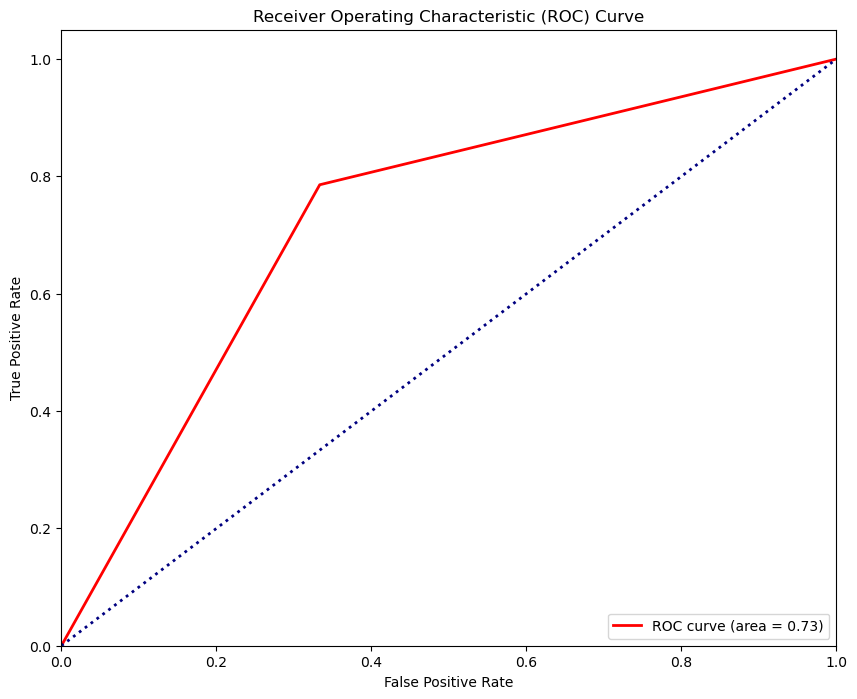

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

auc_plotter(roc_auc)

In [ ]:
print(x_train.shape, x_test.shape)

# The .98 is a parameter that indicates the principal components required to explain 98% of the variance in the dataset
pca= PCA(.98)

pca_train= pca.fit_transform(x_train)
pca_test= pca.transform(x_test)
print('-----After PCA-------\n')
print(pca_train.shape, pca_test.shape)
print("Number of Components: ", pca.n_components_)
print("Number of Original Features: ", pca.n_features_)

(32, 49152) (32, 49152)
-----After PCA-------

(32, 27) (32, 27)
Number of Components:  27
Number of Original Features:  49152


In [ ]:
rf_model_pca = GridSearchCV(RandomForestClassifier(), rf_param_grid, refit=True, verbose=3)

# Train your SVM model on the entire training data
rf_model_pca.fit(pca_train, y_train)
best_params = rf_model_pca.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.571 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=1.000 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.667 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.833 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_split=4, n_estimators=50, random_state=101;, score=1.000 total time=   0.0s
[CV 3/5

[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.833 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.833 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=50, random_state=101;, score=0.833 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=100, random_state=101;, score=0.714 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=100, random_state=101;, score=1.000 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_split=7, n_estimators=100,

[CV 1/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=0.857 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=1.000 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=0.833 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=0.667 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_split=10, n_estimators=100, random_state=101;, score=0.667 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_split=4, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_spl

[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=1.000 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=0.833 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=0.667 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_split=4, n_estimators=100, random_state=101;, score=0.833 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_split=7, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_split=7, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_split=7, n_estimators=10, random_state=101;, score=1.000 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_

[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=7, n_estimators=100, random_state=101;, score=0.833 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=7, n_estimators=100, random_state=101;, score=0.833 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=0.714 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=1.000 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=0.667 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_split=10, n_estimators=10, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, min_sampl

In [ ]:
y_pred = rf_model_pca.predict(pca_test)
print(best_params)
print('\n-----------------------------------------------\n')
print(classification_report(y_test,y_pred))

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 50, 'random_state': 101}

-----------------------------------------------

              precision    recall  f1-score   support

           0       0.92      0.61      0.73        18
           1       0.65      0.93      0.76        14

    accuracy                           0.75        32
   macro avg       0.78      0.77      0.75        32
weighted avg       0.80      0.75      0.75        32



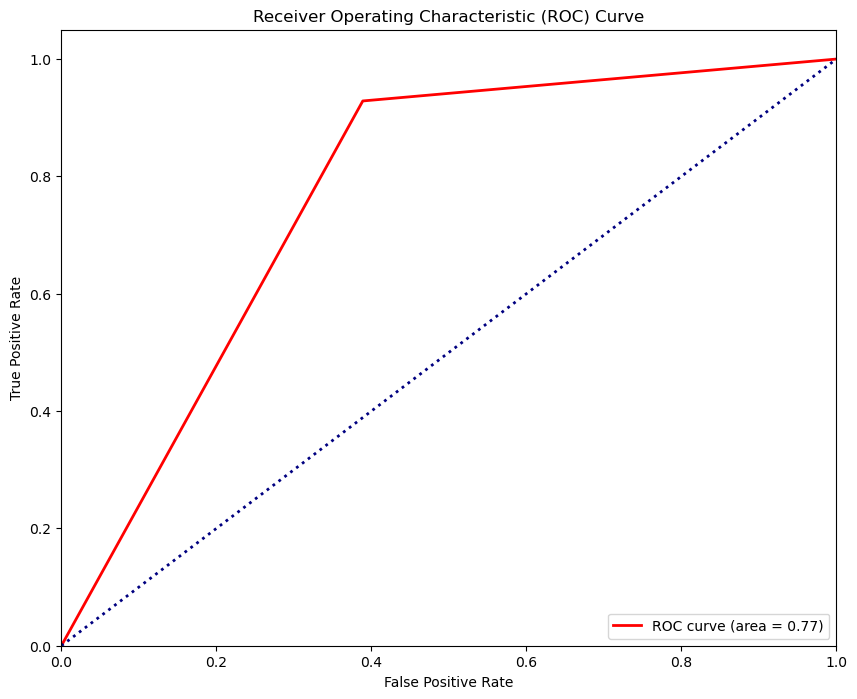

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

auc_plotter(roc_auc)

### XGBoost Classifier

In [ ]:
# Define a generator for the training data
xgb_training_generator = data_generator.flow_from_dataframe(train_files,
                                        x_col='Filepath',
                                        y_col='Label',
                                        shuffle=True,
                                        batch_size=batch_size,
                                        target_size=(128, 128),
                                        class_mode='categorical')

# Define a generator for the testing data
xgb_testing_generator = data_generator.flow_from_dataframe(
        test_files,
        x_col='Filepath',
        y_col='Label',
        shuffle=True,
        batch_size=batch_size,
        target_size=(128, 128),
        class_mode='categorical')

x_train, y_train = xgb_training_generator.next()
x_test, y_test = xgb_testing_generator.next()

# This converts the labels back to their original indices since they are of the form of one-hot-encoded
# vector, the result is a 1D array of class indices, representing class labels for corresponding images in X_train
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Flatten the images into a 2D array, since SVMs expect 2D input arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Found 21175 validated image filenames belonging to 2 classes.
Found 9075 validated image filenames belonging to 2 classes.


In [ ]:
# Define the hyperparameter grid for XGBoost Classifier
xgb_param_grid = {'eta':[0.05,0.1,0.3],
              'min_child_weight': [0.5,1,2],
              'max_depth': [2,3,4],
              'gamma': [0,0.1,1,10],
              'seed': [101]}

In [ ]:
# Create a GridSearchCV object to perform the hyperparameter search
xgb_model = GridSearchCV(XGBClassifier(), xgb_param_grid, refit=True, verbose=3)

xgb_model.fit(x_train, y_train)
best_params = xgb_model.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.571 total time=   2.0s
[CV 2/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.714 total time=   2.0s
[CV 3/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.333 total time=   2.2s
[CV 4/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.667 total time=   2.1s
[CV 5/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.833 total time=   2.1s
[CV 1/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.571 total time=   1.4s
[CV 2/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.714 total time=   1.3s
[CV 3/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.333 total time=   1.5s
[CV 4/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=1

[CV 1/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=0.571 total time=   1.9s
[CV 2/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=0.714 total time=   2.0s
[CV 3/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=0.333 total time=   2.1s
[CV 4/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=0.667 total time=   2.1s
[CV 5/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=0.833 total time=   2.1s
[CV 1/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.571 total time=   1.4s
[CV 2/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.714 total time=   1.3s
[CV 3/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.333 total time=   1.4s
[CV 4/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.667 total time=   1.4s
[CV 5/5] 

[CV 2/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=0.5, seed=101;, score=0.714 total time=   2.7s
[CV 3/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=0.5, seed=101;, score=0.333 total time=   2.9s
[CV 4/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=0.5, seed=101;, score=0.667 total time=   2.9s
[CV 5/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=0.5, seed=101;, score=0.833 total time=   2.9s
[CV 1/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.571 total time=   2.2s
[CV 2/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.714 total time=   2.2s
[CV 3/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.333 total time=   2.4s
[CV 4/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.667 total time=   2.3s
[CV 5/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.833 total time=   2.4s
[CV 1/5] END eta=0.0

[CV 4/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=0.5, seed=101;, score=0.667 total time=   1.5s
[CV 5/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=0.5, seed=101;, score=0.833 total time=   1.5s
[CV 1/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.571 total time=   1.1s
[CV 2/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.714 total time=   1.1s
[CV 3/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.333 total time=   1.1s
[CV 4/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.667 total time=   1.1s
[CV 5/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   1.1s
[CV 1/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.571 total time=   0.9s
[CV 2/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.714 total time=   0.9s
[CV 3/5] END eta=0.1, ga

[CV 1/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=0.571 total time=   1.1s
[CV 2/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=0.714 total time=   1.1s
[CV 3/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=0.333 total time=   1.2s
[CV 4/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=0.667 total time=   1.1s
[CV 5/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=0.833 total time=   1.3s
[CV 1/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=2, seed=101;, score=0.571 total time=   1.0s
[CV 2/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=2, seed=101;, score=0.714 total time=   1.0s
[CV 3/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=2, seed=101;, score=0.333 total time=   0.9s
[CV 4/5] END eta=0.1, gamma=1, max_depth=4, min_child_weight=2, seed=101;, score=0.667 total time=   1.0s
[CV 5/5] END eta=0.1, gamma=1, max_depth=4, mi

[CV 3/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=1, seed=101;, score=0.333 total time=   1.0s
[CV 4/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=1, seed=101;, score=0.667 total time=   0.9s
[CV 5/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=1, seed=101;, score=0.833 total time=   0.9s
[CV 1/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=2, seed=101;, score=0.571 total time=   0.8s
[CV 2/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=2, seed=101;, score=0.714 total time=   0.8s
[CV 3/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=2, seed=101;, score=0.333 total time=   0.9s
[CV 4/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=2, seed=101;, score=0.667 total time=   0.9s
[CV 5/5] END eta=0.3, gamma=0, max_depth=3, min_child_weight=2, seed=101;, score=0.833 total time=   0.9s
[CV 1/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=0.5, seed=101;, score=0.571 total time=   1.0s
[CV 2/5] END eta=0.3, gamma=0, max_depth=4, 

[CV 4/5] END eta=0.3, gamma=1, max_depth=2, min_child_weight=1, seed=101;, score=0.667 total time=   1.0s
[CV 5/5] END eta=0.3, gamma=1, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   1.0s
[CV 1/5] END eta=0.3, gamma=1, max_depth=2, min_child_weight=2, seed=101;, score=0.571 total time=   1.0s
[CV 2/5] END eta=0.3, gamma=1, max_depth=2, min_child_weight=2, seed=101;, score=0.714 total time=   0.8s
[CV 3/5] END eta=0.3, gamma=1, max_depth=2, min_child_weight=2, seed=101;, score=0.333 total time=   0.9s
[CV 4/5] END eta=0.3, gamma=1, max_depth=2, min_child_weight=2, seed=101;, score=0.667 total time=   0.9s
[CV 5/5] END eta=0.3, gamma=1, max_depth=2, min_child_weight=2, seed=101;, score=0.833 total time=   0.9s
[CV 1/5] END eta=0.3, gamma=1, max_depth=3, min_child_weight=0.5, seed=101;, score=0.571 total time=   1.7s
[CV 2/5] END eta=0.3, gamma=1, max_depth=3, min_child_weight=0.5, seed=101;, score=0.714 total time=   1.7s
[CV 3/5] END eta=0.3, gamma=1, max_depth=3

[CV 1/5] END eta=0.3, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.571 total time=   1.5s
[CV 2/5] END eta=0.3, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.714 total time=   1.5s
[CV 3/5] END eta=0.3, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.333 total time=   1.6s
[CV 4/5] END eta=0.3, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.667 total time=   1.6s
[CV 5/5] END eta=0.3, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.833 total time=   1.6s


In [ ]:
y_pred = xgb_model.predict(x_test)
print(best_params)
print('\n-----------------------------------------------\n')
print(classification_report(y_test,y_pred))

{'eta': 0.05, 'gamma': 0, 'max_depth': 2, 'min_child_weight': 0.5, 'seed': 101}

-----------------------------------------------

              precision    recall  f1-score   support

           0       0.57      0.62      0.59        13
           1       0.72      0.68      0.70        19

    accuracy                           0.66        32
   macro avg       0.65      0.65      0.65        32
weighted avg       0.66      0.66      0.66        32



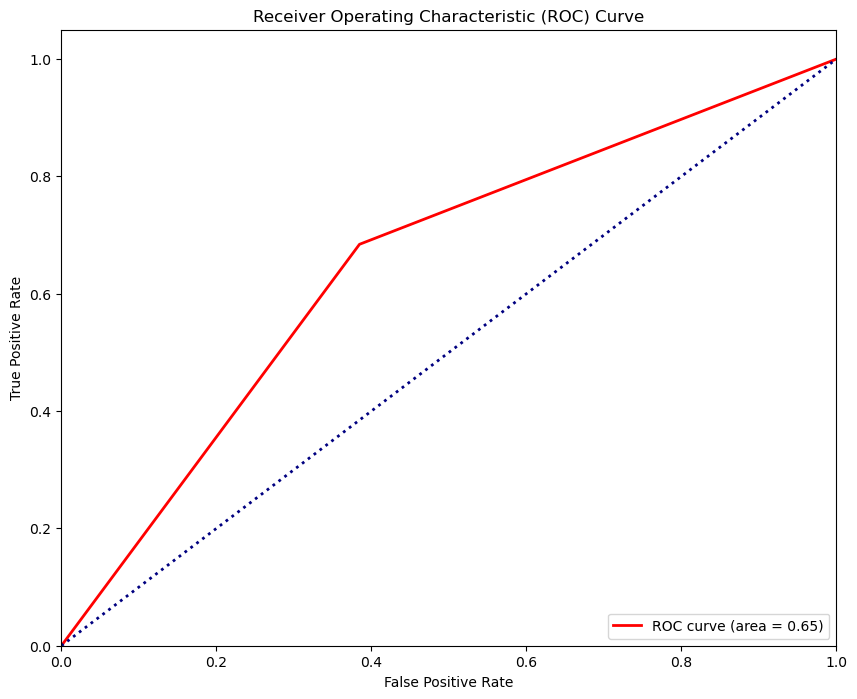

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

auc_plotter(roc_auc)

In [ ]:
print(x_train.shape, x_test.shape)

# The .98 is a parameter that indicates the principal components required to explain 98% of the variance in the dataset
pca= PCA(.98)

pca_train= pca.fit_transform(x_train)
pca_test= pca.transform(x_test)
print('-----After PCA-------\n')
print(pca_train.shape, pca_test.shape)
print("Number of Components: ", pca.n_components_)
print("Number of Original Features: ", pca.n_features_)

(32, 49152) (32, 49152)
-----After PCA-------

(32, 27) (32, 27)
Number of Components:  27
Number of Original Features:  49152


In [ ]:
xgb_model_pca = GridSearchCV(XGBClassifier(), xgb_param_grid, refit=True, verbose=3)

# Train your SVM model on the entire training data
xgb_model_pca.fit(pca_train, y_train)
best_params = xgb_model_pca.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=1

[CV 4/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=1.000 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=2, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=2, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END et

[CV 2/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=2, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=2, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=10, max_depth=3, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.05, gamma

[CV 1/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=1.000 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.1, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 5/5] END eta=0.1

[CV 1/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=0.5, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=0.5, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=0.5, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.1, gamma

[CV 4/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=1, seed=101;, score=1.000 total time=   0.0s
[CV 5/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=2, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=2, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.3, gamma=0, max_depth=4, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.3, gamma=0.1, max_d

[CV 5/5] END eta=0.3, gamma=1, max_depth=3, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 4/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 5/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=0.5, seed=101;, score=1.000 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=1.000 total time=   0.0s
[CV 2/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=0.714 total time=   0.0s
[CV 3/5] END eta=0.3, gamma=1, max_depth=4, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 4/5] END eta=0.3, gamma=1, max_d

In [ ]:
y_pred = xgb_model_pca.predict(pca_test)
print(best_params)
print('\n-----------------------------------------------\n')
print(classification_report(y_test,y_pred))

{'eta': 0.05, 'gamma': 0, 'max_depth': 2, 'min_child_weight': 0.5, 'seed': 101}

-----------------------------------------------

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.95      0.95      0.95        19

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



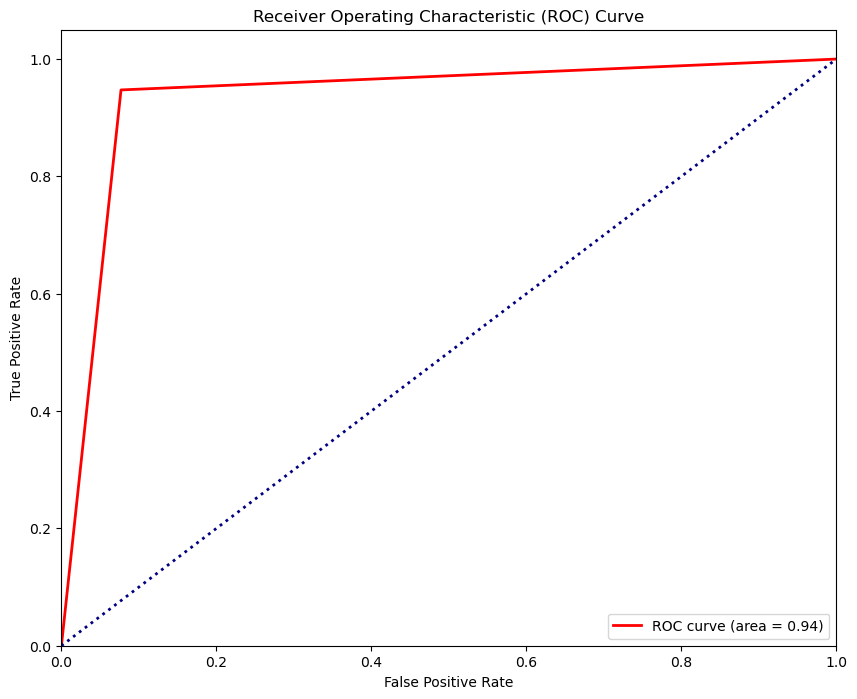

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

auc_plotter(roc_auc)

### CNN Model

In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

In [ ]:
!wandb login

wandb: Currently logged in as: user_88. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.init(project='wildfire_prediction', entity='user_88')

wandb: Currently logged in as: user_88. Use `wandb login --relogin` to force relogin


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam

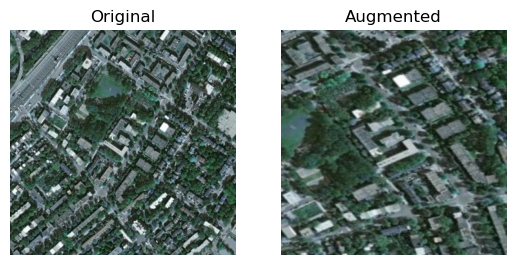

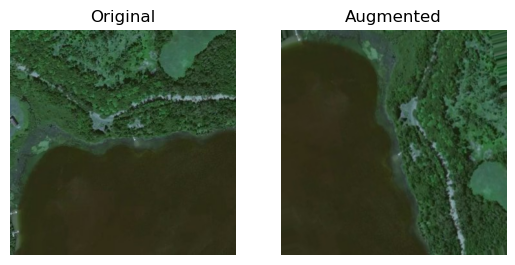

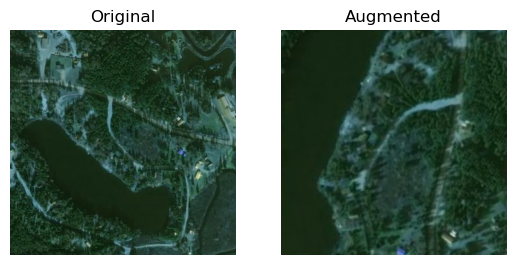

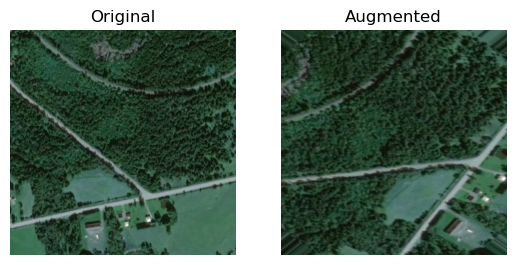

In [ ]:
def image_augmenter(image):
    datagen = ImageDataGenerator(rotation_range=90, zoom_range=[0.5, 1.0])
    image = np.expand_dims(image, axis=0)  # Add an extra dimension
    augmented_image = datagen.flow(x=image, batch_size=1)[0]
    augmented_image = augmented_image.squeeze(axis=0)  # Remove the extra dimension
    return augmented_image.astype(image.dtype)  # Preserve the data type of the input image

def show_original_vs_augmented(df, nsample):
    data = df.sample(nsample)
    for i in range(len(data)):
        image = cv2.imread(data.iloc[i].Filepath)
        augmented_image = image_augmenter(image)

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(augmented_image)
        plt.title("Augmented")
        plt.axis('off')
        plt.show()

show_original_vs_augmented(training_data_df, 4)

In [ ]:
##We will choose a batch size of 256, since it leads to a more stable and efficient training, due to its larger size
##We will choose the 'categorical' class_mode since our classes are not 0 and 1, so it reduces the hassle of converting the class types

tr_dg= ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=image_augmenter)
training_generator = tr_dg.flow_from_dataframe(training_data_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = 256,
                                                    target_size = (256,256),
                                                    class_mode = 'categorical')

val_dg = ImageDataGenerator(dtype='float32', rescale= 1./255.)
validation_generator = val_dg.flow_from_dataframe(validation_data_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = 256,
                                                    target_size = (256,256),
                                                    class_mode = 'categorical')
te_dg = ImageDataGenerator(dtype='float32', rescale= 1./255.)
testing_generator = te_dg.flow_from_dataframe(testing_data_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=False,
                                                    batch_size = 256,
                                                    target_size = (256,256),
                                                    class_mode = 'categorical')

Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


In [ ]:
### TO FIX NEXT LINES -- DON'T RUN

In [ ]:
inputs = Input(shape=(256, 256, 3))

##Convolutional Layer 1
x = Conv2D(filters = 8, kernel_size=2)(inputs)
x = MaxPooling2D()(x)

##Convolutional Layer 2
x = Conv2D(filters = 16, kernel_size=2)(x)
x = MaxPooling2D()(x)

##Convolutional Layer 3
x = Conv2D(filters = 32, kernel_size=2)(x)
x = MaxPooling2D()(x)

##Fully Connected Layer 1 with Dropout function to reduce overfitting
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(.3)(x)

##Fully Connected Layer 2 with Dropout function to reduce overfitting
x = Dense(128, activation="relu")(x)
x = Dropout(.3)(x)

##Output Layer
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

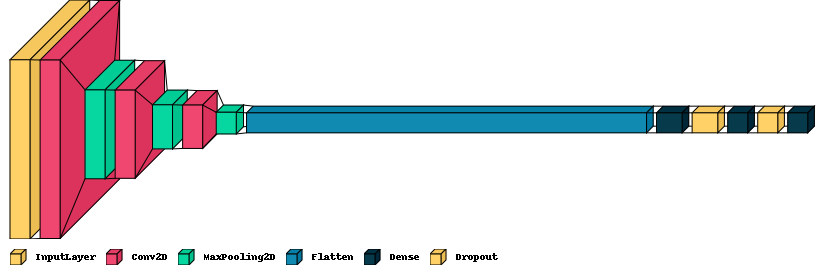

In [ ]:
from PIL import ImageFont
import visualkeras

visualkeras.layered_view(model,scale_xy=0.7,legend= True)

In [ ]:
model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)
checkpoint = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
stopping = EarlyStopping(monitor= 'val_loss', patience= 9)

history = model.fit(training_generator,
                    epochs = 50,
                    verbose = 1,
                    validation_data = validation_generator,
                    callbacks = [wandb.keras.WandbCallback(), checkpoint, stopping])



Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.8703 - auc: 0.9358

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00001: val_loss improved from inf to 0.20959, saving model to model.hdf5
119/119 [==============================] - 775s 6s/step - loss: 0.3330 - accuracy: 0.8703 - auc: 0.9358 - val_loss: 0.2096 - val_accuracy: 0.9183 - val_auc: 0.9703
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9089 - auc: 0.9622
Epoch 00002: val_loss did not improve from 0.20959
119/119 [==============================] - 636s 5s/step - loss: 0.2393 - accuracy: 0.9089 - auc: 0.9622 - val_loss: 0.2235 - val_accuracy: 0.9095 - val_auc: 0.9624
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9180 - auc: 0.9686

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00003: val_loss improved from 0.20959 to 0.18670, saving model to model.hdf5
119/119 [==============================] - 652s 5s/step - loss: 0.2131 - accuracy: 0.9180 - auc: 0.9686 - val_loss: 0.1867 - val_accuracy: 0.9251 - val_auc: 0.9725
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9192 - auc: 0.9692

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00004: val_loss improved from 0.18670 to 0.14661, saving model to model.hdf5
119/119 [==============================] - 639s 5s/step - loss: 0.2101 - accuracy: 0.9192 - auc: 0.9692 - val_loss: 0.1466 - val_accuracy: 0.9459 - val_auc: 0.9821
Epoch 5/50
119/119 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9263 - auc: 0.9735
Epoch 00005: val_loss did not improve from 0.14661
119/119 [==============================] - 636s 5s/step - loss: 0.1915 - accuracy: 0.9263 - auc: 0.9735 - val_loss: 0.1710 - val_accuracy: 0.9297 - val_auc: 0.9772
Epoch 6/50
119/119 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9302 - auc: 0.9755
Epoch 00006: val_loss did not improve from 0.14661
119/119 [==============================] - 636s 5s/step - loss: 0.1846 - accuracy: 0.9302 - auc: 0.9755 - val_loss: 0.1565 - val_accuracy: 0.9373 - val_auc: 0.9806
Epoch 7/50
119/119 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9282 - auc:

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.3s



Epoch 00007: val_loss improved from 0.14661 to 0.14408, saving model to model.hdf5
119/119 [==============================] - 641s 5s/step - loss: 0.1836 - accuracy: 0.9282 - auc: 0.9759 - val_loss: 0.1441 - val_accuracy: 0.9433 - val_auc: 0.9827
Epoch 8/50
119/119 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9283 - auc: 0.9736

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00008: val_loss improved from 0.14408 to 0.13621, saving model to model.hdf5
119/119 [==============================] - 643s 5s/step - loss: 0.1891 - accuracy: 0.9283 - auc: 0.9736 - val_loss: 0.1362 - val_accuracy: 0.9481 - val_auc: 0.9846
Epoch 9/50
119/119 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9310 - auc: 0.9753
Epoch 00009: val_loss did not improve from 0.13621
119/119 [==============================] - 645s 5s/step - loss: 0.1823 - accuracy: 0.9310 - auc: 0.9753 - val_loss: 0.1417 - val_accuracy: 0.9470 - val_auc: 0.9825
Epoch 10/50
119/119 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9321 - auc: 0.9758
Epoch 00010: val_loss did not improve from 0.13621
119/119 [==============================] - 635s 5s/step - loss: 0.1791 - accuracy: 0.9321 - auc: 0.9758 - val_loss: 0.1497 - val_accuracy: 0.9473 - val_auc: 0.9806
Epoch 11/50
119/119 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9324 - au

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00012: val_loss improved from 0.13621 to 0.12857, saving model to model.hdf5
119/119 [==============================] - 632s 5s/step - loss: 0.1716 - accuracy: 0.9334 - auc: 0.9779 - val_loss: 0.1286 - val_accuracy: 0.9500 - val_auc: 0.9849
Epoch 13/50
119/119 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9344 - auc: 0.9772
Epoch 00013: val_loss did not improve from 0.12857
119/119 [==============================] - 629s 5s/step - loss: 0.1725 - accuracy: 0.9344 - auc: 0.9772 - val_loss: 0.1334 - val_accuracy: 0.9502 - val_auc: 0.9853
Epoch 14/50
119/119 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9342 - auc: 0.9782
Epoch 00014: val_loss did not improve from 0.12857
119/119 [==============================] - 639s 5s/step - loss: 0.1709 - accuracy: 0.9342 - auc: 0.9782 - val_loss: 0.1480 - val_accuracy: 0.9449 - val_auc: 0.9806
Epoch 15/50
119/119 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9359 - a

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00017: val_loss improved from 0.12857 to 0.12379, saving model to model.hdf5
119/119 [==============================] - 630s 5s/step - loss: 0.1657 - accuracy: 0.9360 - auc: 0.9789 - val_loss: 0.1238 - val_accuracy: 0.9548 - val_auc: 0.9847
Epoch 18/50
119/119 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9786
Epoch 00018: val_loss did not improve from 0.12379
119/119 [==============================] - 634s 5s/step - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9786 - val_loss: 0.1336 - val_accuracy: 0.9484 - val_auc: 0.9847
Epoch 19/50
119/119 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9389 - auc: 0.9801
Epoch 00019: val_loss did not improve from 0.12379
119/119 [==============================] - 624s 5s/step - loss: 0.1609 - accuracy: 0.9389 - auc: 0.9801 - val_loss: 0.1590 - val_accuracy: 0.9365 - val_auc: 0.9800
Epoch 20/50
119/119 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9394 - a

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00025: val_loss improved from 0.12379 to 0.12250, saving model to model.hdf5
119/119 [==============================] - 621s 5s/step - loss: 0.1538 - accuracy: 0.9414 - auc: 0.9816 - val_loss: 0.1225 - val_accuracy: 0.9521 - val_auc: 0.9861
Epoch 26/50
119/119 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9421 - auc: 0.9819
Epoch 00026: val_loss did not improve from 0.12250
119/119 [==============================] - 631s 5s/step - loss: 0.1514 - accuracy: 0.9421 - auc: 0.9819 - val_loss: 0.1245 - val_accuracy: 0.9538 - val_auc: 0.9852
Epoch 27/50
119/119 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9430 - auc: 0.9825
Epoch 00027: val_loss did not improve from 0.12250
119/119 [==============================] - 630s 5s/step - loss: 0.1487 - accuracy: 0.9430 - auc: 0.9825 - val_loss: 0.1340 - val_accuracy: 0.9487 - val_auc: 0.9839
Epoch 28/50
119/119 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9428 - a

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00033: val_loss improved from 0.12250 to 0.12045, saving model to model.hdf5
119/119 [==============================] - 675s 6s/step - loss: 0.1454 - accuracy: 0.9435 - auc: 0.9825 - val_loss: 0.1205 - val_accuracy: 0.9546 - val_auc: 0.9864
Epoch 34/50
119/119 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9441 - auc: 0.9834

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00034: val_loss improved from 0.12045 to 0.11211, saving model to model.hdf5
119/119 [==============================] - 636s 5s/step - loss: 0.1437 - accuracy: 0.9441 - auc: 0.9834 - val_loss: 0.1121 - val_accuracy: 0.9579 - val_auc: 0.9878
Epoch 35/50
119/119 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9447 - auc: 0.9830
Epoch 00035: val_loss did not improve from 0.11211
119/119 [==============================] - 635s 5s/step - loss: 0.1440 - accuracy: 0.9447 - auc: 0.9830 - val_loss: 0.1646 - val_accuracy: 0.9349 - val_auc: 0.9775
Epoch 36/50
119/119 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9823
Epoch 00036: val_loss did not improve from 0.11211
119/119 [==============================] - 631s 5s/step - loss: 0.1482 - accuracy: 0.9430 - auc: 0.9823 - val_loss: 0.1211 - val_accuracy: 0.9519 - val_auc: 0.9855
Epoch 37/50
119/119 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9455 - a

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230804_212610-w5d28y5p\files\model-best)... Done. 0.2s



Epoch 00040: val_loss improved from 0.11211 to 0.11160, saving model to model.hdf5
119/119 [==============================] - 634s 5s/step - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9820 - val_loss: 0.1116 - val_accuracy: 0.9594 - val_auc: 0.9879
Epoch 41/50
119/119 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9473 - auc: 0.9839
Epoch 00041: val_loss did not improve from 0.11160
119/119 [==============================] - 648s 5s/step - loss: 0.1398 - accuracy: 0.9473 - auc: 0.9839 - val_loss: 0.1286 - val_accuracy: 0.9552 - val_auc: 0.9846
Epoch 42/50
119/119 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9469 - auc: 0.9839
Epoch 00042: val_loss did not improve from 0.11160
119/119 [==============================] - 643s 5s/step - loss: 0.1391 - accuracy: 0.9469 - auc: 0.9839 - val_loss: 0.1344 - val_accuracy: 0.9467 - val_auc: 0.9844
Epoch 43/50
119/119 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9480 - a

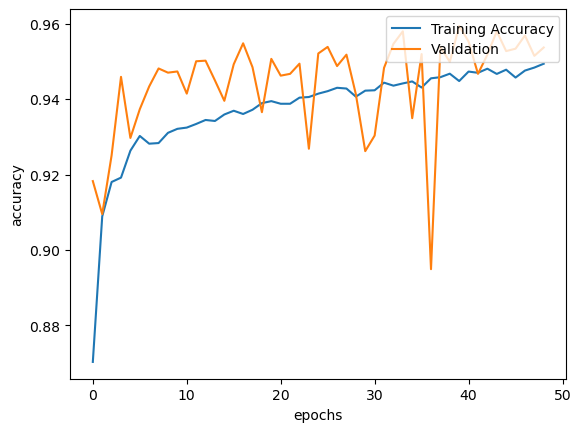

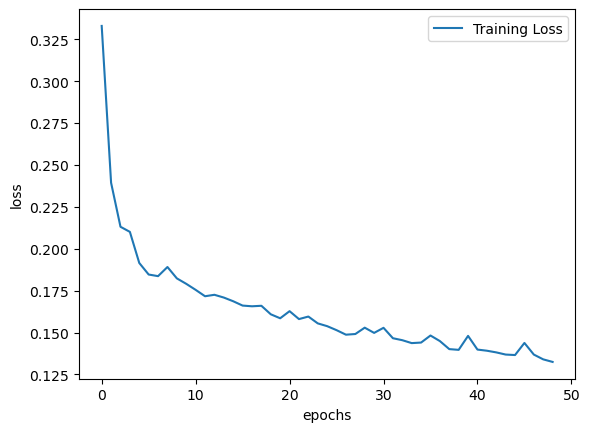

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation')

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

25/25 [==============================] - 30s 1s/step
Accuracy score: 96.42857142857143


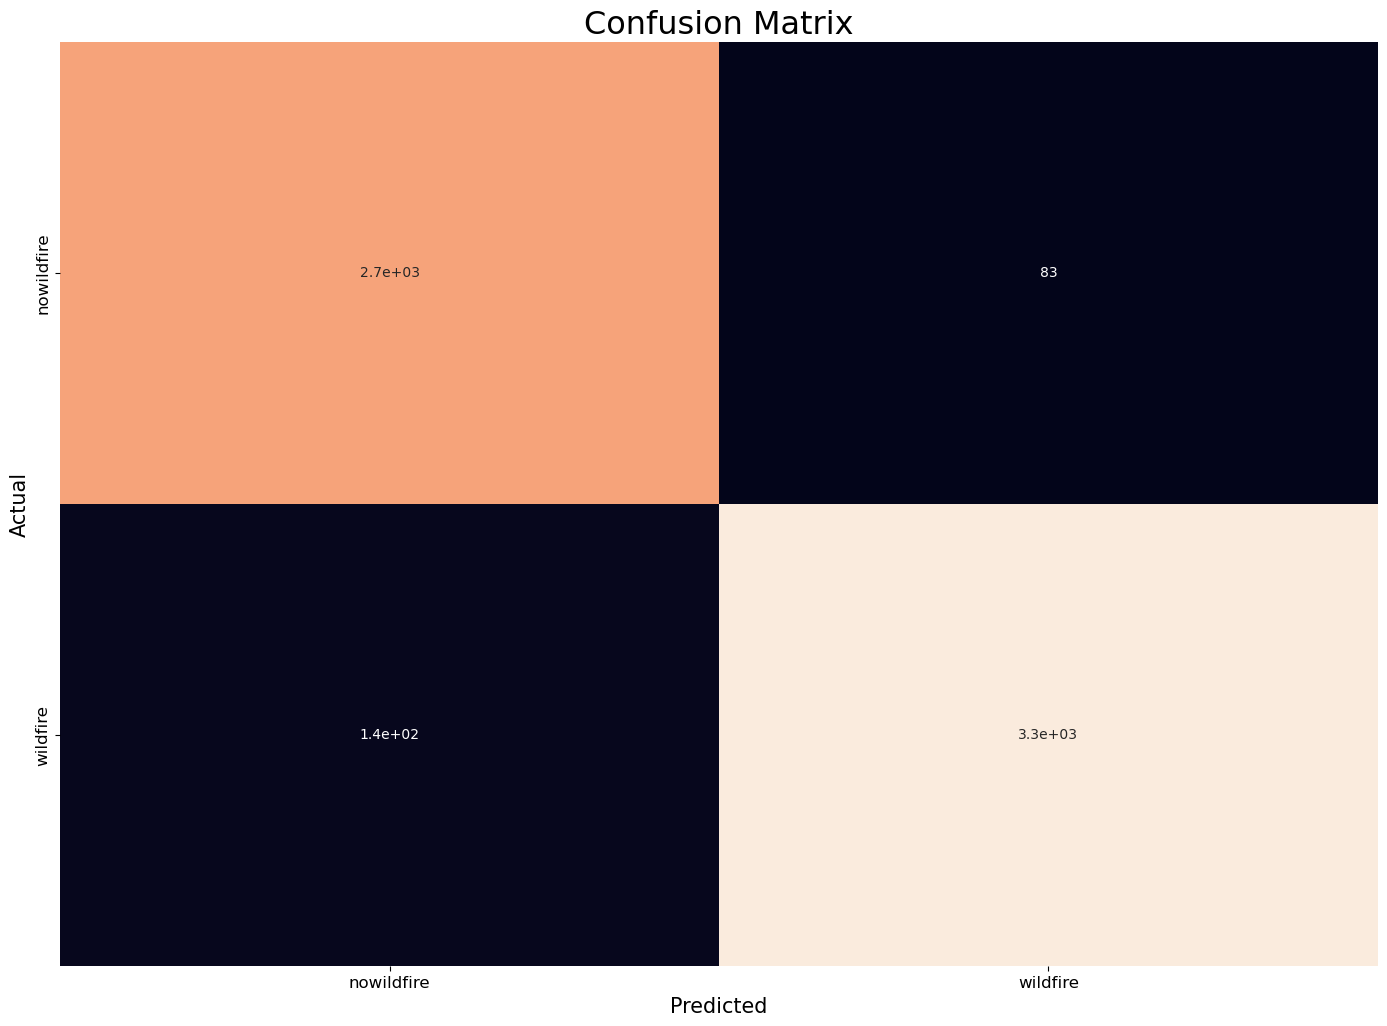

In [ ]:
prediction = np.argmax(model.predict(testing_generator), axis=1)

labels = (testing_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction_label = [labels[k] for k in prediction]
y_test = list(testing_data_df.Label)

# Print accuracy score
score = accuracy_score(y_test,prediction_label)
print(f'Accuracy score: {score * 100}')

# Plot confusion matrix
cfm = confusion_matrix(y_test, prediction_label, normalize= None)
plt.figure(figsize = (17,12))
sb.heatmap(cfm, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

In [ ]:
print(classification_report(y_test, prediction_label))

              precision    recall  f1-score   support

  nowildfire       0.95      0.97      0.96      2820
    wildfire       0.98      0.96      0.97      3480

    accuracy                           0.96      6300
   macro avg       0.96      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300



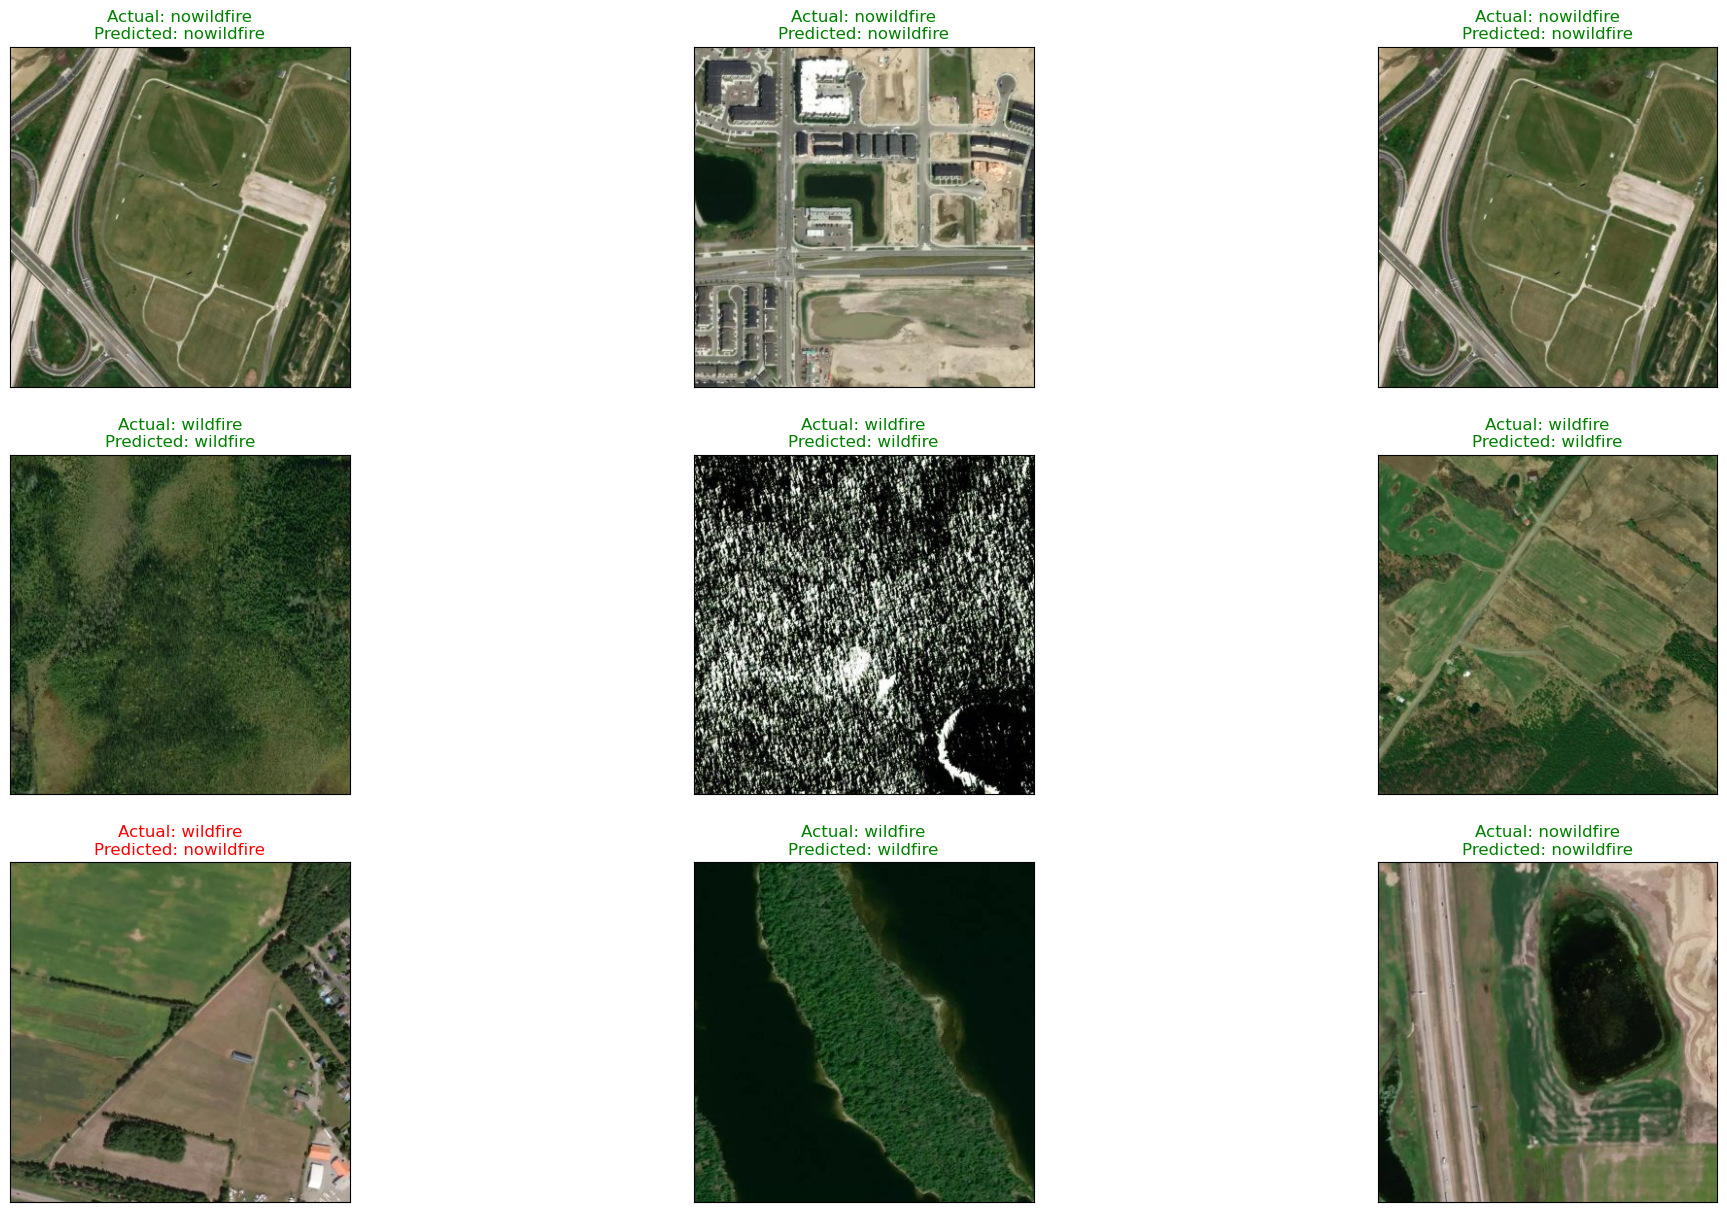

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0, len(x_test) - 1, 9)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_generator.filepaths[random_index[i]]))
    if labels[testing_generator.labels[random_index[i]]] == prediction_label[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"Actual: {labels[testing_generator.labels[random_index[i]]]}\nPredicted: {prediction_label[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()